In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
survey_df = pd.read_csv('../data/online-v1-prolific-sample.csv')
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Q_work_urban,Q_work_urban_3_TEXT,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,PROLIFIC_PID,STUDY_ID,treatment
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Do you work in an urban area? - Selected Choice,Do you work in an urban area? - Not sure / Oth...,How old are you?,What is your gender?,What was your total household income before ta...,Choose one or more races that you consider you...,Any extra comments? (optional),PROLIFIC_PID,STUDY_ID,treatment
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID63""}","{""ImportId"":""QID63_3_TEXT""}","{""ImportId"":""QID30""}","{""ImportId"":""QID57""}","{""ImportId"":""QID25""}","{""ImportId"":""QID24""}","{""ImportId"":""QID58_TEXT""}","{""ImportId"":""PROLIFIC_PID""}","{""ImportId"":""STUDY_ID""}","{""ImportId"":""treatment""}"
2,2022-06-28 09:30:49,2022-06-28 09:32:52,0,*******,100,123,1,2022-06-28 09:32:52,R_125SdSXI0xLI29S,*******,...,1,NaN,4,1,6,1,NaN,5ae11f9709eae20001132c22,62bb1ba7f2c710e36fd2c1be,labeled
3,2022-06-28 09:30:31,2022-06-28 09:34:22,0,*******,100,231,1,2022-06-28 09:34:23,R_23V4Eyckqxl6Bmy,*******,...,2,NaN,7,1,5,1,I do not lean toward either party. I am a libe...,5dd311bde25acf3254f36c9c,62bb1ba7f2c710e36fd2c1be,unlabeled
4,2022-06-28 09:31:35,2022-06-28 09:35:34,0,*******,100,239,1,2022-06-28 09:35:35,R_2c5wLF9HxTeZ30h,*******,...,2,NaN,5,2,2,1,"None, but thank you!",5ba3e40d2d28760001a377bb,62bb1ba7f2c710e36fd2c1bf,labeled


In [3]:
print(list(survey_df.columns))

['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference', 'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 'ProlificID ', 'Q_attn_1', 'Q_attn_2', 'Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled', 'Q_attn_check', 'Q_current_hunger', 'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5', 'Q_special_diet', 'Q_special_diet_6_TEXT', 'Q_past_vegetarian', 'Q_past_vegan', 'Q_vegetarian_not_me', 'Q_vegan_not_me', 'Q_good_for_env', 'Q_how_important_env', 'Q_attn_midway', 'Q_politics', 'Q_US_state', 'Q_live_urban', 'Q_work_urban', 'Q_work_urban_3_TEXT', 'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 'Q_comments', 'PR

## Data preprocessing


Transform into tables:


1. Respondent data table:

Contains all relevant non-choice data for a respondent

2. Menu choices table

```
ResponseId, labeled (1/0), QID, menu, comparison type (1-5), choice (1/0) 
```

In [4]:
choice_Q_prefix = 'Q_sandwich'
choice_Qs = [q for q in survey_df.columns if q.startswith(choice_Q_prefix)]
print(choice_Qs)

['Q_sandwich_1', 'Q_sandwich_2', 'Q_sandwich_3', 'Q_sandwich_4', 'Q_sandwich_5', 'Q_sandwich_1_labeled', 'Q_sandwich_2_labeled', 'Q_sandwich_3_labeled', 'Q_sandwich_4_labeled', 'Q_sandwich_5_labeled']


In [5]:
# extract the columns we use
respondent_columns = [
    'ResponseId', 
    'PROLIFIC_PID', # embedded variable set through URL params
    'Finished','Duration (in seconds)', 'RecordedDate',
    'Q_attn_1', 'Q_attn_2', 'Q_attn_check', 'Q_attn_midway', 
    'Q_current_hunger', 'Q_live_urban', 'Q_work_urban', 'Q_politics', 'Q_US_state',
    'Q_priorities_1', 'Q_priorities_2', 'Q_priorities_3', 'Q_priorities_4', 'Q_priorities_5',
    'Q_special_diet', 'Q_special_diet_6_TEXT', 
    'Q_past_vegetarian', 'Q_past_vegan', 
    'Q_vegetarian_not_me', 'Q_vegan_not_me', 
    'Q_good_for_env', 'Q_how_important_env',
    'Q_demos_age', 'Q_demos_gender', 'Q_demos_income', 'Q_demos_race', 
    'Q_comments',
    'treatment'
]

### Respondent table

In [6]:
respondent_df = survey_df.drop([0,1])[respondent_columns]
starting_respondent_N = respondent_df['ResponseId'].nunique()
print('N=%s total responses before data cleaning' % starting_respondent_N)
respondent_df.head(3)

N=669 total responses before data cleaning


,ResponseId,PROLIFIC_PID,Finished,Duration (in seconds),RecordedDate,Q_attn_1,Q_attn_2,Q_attn_check,Q_attn_midway,Q_current_hunger,...,Q_vegetarian_not_me,Q_vegan_not_me,Q_good_for_env,Q_how_important_env,Q_demos_age,Q_demos_gender,Q_demos_income,Q_demos_race,Q_comments,treatment
2,R_125SdSXI0xLI29S,5ae11f9709eae20001132c22,1,123,2022-06-28 09:32:52,21,5,"1,2",5,3,...,4,4,2,4,4,1,6,1,NaN,labeled
3,R_23V4Eyckqxl6Bmy,5dd311bde25acf3254f36c9c,1,231,2022-06-28 09:34:23,21,5,"1,2",5,2,...,3,3,2,4,7,1,5,1,I do not lean toward either party. I am a libe...,unlabeled
4,R_2c5wLF9HxTeZ30h,5ba3e40d2d28760001a377bb,1,239,2022-06-28 09:35:35,21,5,"1,2",5,2,...,4,4,1,5,5,2,2,1,"None, but thank you!",labeled


In [7]:
# only include completed surveys via Prolific
N_PROLIFIC_PID_na = len(respondent_df[respondent_df['PROLIFIC_PID'].isna()])
print('dropping %s non PROLIFIC responses' % N_PROLIFIC_PID_na)
respondent_df = respondent_df[respondent_df['PROLIFIC_PID'].notna()]
N_uncompleted = len(respondent_df[respondent_df['Finished'] != '1'])
respondent_df = respondent_df[respondent_df['Finished'] == '1']
print('dropping %s incomplete responses' % N_uncompleted)

dropping 1 non PROLIFIC responses
dropping 4 incomplete responses


In [8]:
def passed_attn_checks(row):
    if not ((row['Q_attn_1'] == 'twenty one') or (int(row['Q_attn_1']) == 21)):
        print(row['ResponseId'], 'failed Q_attn_1')
        return False
    if int(row['Q_attn_2']) != 5:
        print(row['ResponseId'], 'failed Q_attn_2')
        return False
    if row['Q_attn_check'] != '1,2':
        print(row['ResponseId'], 'failed Q_attn_check')
        return False
    if int(row['Q_attn_midway']) != 5:
        print(row['ResponseId'], 'failed Q_attn_midway')
        return False
    return True

In [9]:
respondent_df['passed_attn_checks'] = respondent_df.apply(passed_attn_checks, axis=1)
passed_attn_checks_ResponseId_list = list(respondent_df[respondent_df.passed_attn_checks == True].ResponseId)
print('%s/%s respondents passed all attention checks' % (len(passed_attn_checks_ResponseId_list), len(respondent_df)))
# passed_attn_checks_ResponseId_list

R_1Nagt8YYb9KXsgu failed Q_attn_check
R_25u12nxsbq17quY failed Q_attn_2
R_1ewLnYbEh64px5y failed Q_attn_2
R_3EbCFbWypJAH9eU failed Q_attn_2
R_31sGHSw29sejYZu failed Q_attn_check
R_XNtU8UZMHfqK8lX failed Q_attn_2
R_1Ov4PG2EqkoaNBI failed Q_attn_2
R_2sbRJWBoxeF0yHs failed Q_attn_2
R_3Hho2J2KAXLsDob failed Q_attn_2
R_3HUPi75tTdT9pnD failed Q_attn_2
R_1eLSotOLp5DjqJP failed Q_attn_2
R_1LLnNW2RfOKf93z failed Q_attn_midway
R_3fvnmHGH7Bmp938 failed Q_attn_2
R_33mAmfZaIBDBZiT failed Q_attn_2
R_3g8l72aZYNXtcZh failed Q_attn_check
R_1CjxgolIeuRdypP failed Q_attn_check
R_UDAbbOpDeLg8Jot failed Q_attn_check
R_1HqLpaBDw6P827V failed Q_attn_2
R_pR8DHCNXAHa8ZFv failed Q_attn_2
R_ahgvJfr1UphyDap failed Q_attn_check
R_1GVKbaKQiuw141N failed Q_attn_2
R_3lDnbCj1Va514U1 failed Q_attn_midway
R_3CB2nXKtOtqSghu failed Q_attn_check
R_d6luDeloHVBgY8N failed Q_attn_check
640/664 respondents passed all attention checks


Drop responses from participants who failed ANY attention check

In [10]:
print('dropping responses from participants who failed any attention check')
respondent_df = respondent_df[respondent_df['passed_attn_checks']]

dropping responses from participants who failed any attention check


### Codebook

In [11]:
# This is a dump from the recode values exported from qualtrics Q_US_state.
# Qualtrics put the states in alphabetical order for their recode value, did not code by FIPs
states_recode_text = '1\nAlabama\n2\nAlaska\n3\nArizona\n4\nArkansas\n5\nCalifornia\n6\nColorado\n7\nConnecticut\n8\nDelaware\n9\nDistrict of Columbia\n10\nFlorida\n11\nGeorgia\n12\nHawaii\n13\nIdaho\n14\nIllinois\n15\nIndiana\n16\nIowa\n17\nKansas\n18\nKentucky\n19\nLouisiana\n20\nMaine\n21\nMaryland\n22\nMassachusetts\n23\nMichigan\n24\nMinnesota\n25\nMississippi\n26\nMissouri\n27\nMontana\n28\nNebraska\n29\nNevada\n30\nNew Hampshire\n31\nNew Jersey\n32\nNew Mexico\n33\nNew York\n34\nNorth Carolina\n35\nNorth Dakota\n36\nOhio\n37\nOklahoma\n38\nOregon\n39\nPennsylvania\n40\nPuerto Rico\n41\nRhode Island\n42\nSouth Carolina\n43\nSouth Dakota\n44\nTennessee\n45\nTexas\n46\nUtah\n47\nVermont\n48\nVirginia\n49\nWashington\n50\nWest Virginia\n51\nWisconsin\n52\nWyoming\n53\nI do not reside in the United States'
states_recode_list = states_recode_text.split('\n')
states_choices_map = {states_recode_list[i]: states_recode_list[i+1] for i in range(0, len(states_recode_list), 2)}
# states_choices_map

In [12]:
# {QID: {Q: Q text, choices: map}}
codebook = {
    'Q_current_hunger': {
        'Q': 'How would you rank your current hunger level on a scale from 1 - 4?',
        'choices': {
            '1':'1 (Not hungry at all)','2':'2','3':'3','4':'4 (Very hungry)'
        },
    },
    'Q_special_diet':{
        'Q': 'Are you on any special diet? (select all that apply)',
        'choices': {
            '1':'Keto','2':'Pescatarian','3':'Vegetarian',
            '4':'Gluten free','5':'Vegan','6':'Other','7':'None'
        },
    },
    'Q_past_vegetarian': {
        'Q':'In the past 7 days, on how many days did you have a meal that contained any meat, poultry, or fish?',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_past_vegan': {
        'Q':'In the past 7 days, on how many days did you eat a meal that contained any kind of animal product? (i.e. on how many days did you eat meat, poultry, fish, dairy, eggs, etc?)',
        'choices': {
            '7': 7,
            '6': 6,
            '5': 5,
            '4': 4,
            '3': 3,
            '2': 2,
            '1': 1,
            '0': 0,
        },
    },
    'Q_priorities': {
        'Q': 'How do you prioritize the following when choosing what to order for yourself off a menu?',
        'choices': {'1':'health','2':'cost','3':'taste','4':'filling','5':'usual_choice'},
    },
    'Q_good_for_env': {
        'Q':'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_how_important_env': {
        'Q':'How important is environmental sustainability to you as an issue?',
        'choices': {
            '1':'Very much not important','2':'Not important',
            '3':'Neutral','4':'Somewhat important','5':'Very important'
        },
    },
    'Q_vegetarian_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegetarian dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_vegan_not_me': {
        'Q': 'How strongly do you agree with the following statement?\n"Vegan dishes are not for people like me."',
        'choices': {
            '1':'Strongly agree','2':'Agree','3':'Neutral',
            '4':'Disagree','5':'Strongly disagree'
        },
    },
    'Q_politics': {
        'Q':'Which of the following best describes your political preference?',
        'choices': {
            '1':'Strongly Democratic','2':'Democratic',
            '3':'Lean Democratic','4':'Lean Republican','5':'Republican','6':'Strongly Republican'
        }
    },
    'Q_live_urban': {
        'Q':'Which best describes the area you live?',
        'choices': {'1':'Urban','2':'Suburban','3':'Rural'},
    },
    'Q_work_urban': {
        'Q': 'Do you work in an urban area?',
        'choices': {'1':'Yes', '2':'No','3':'Not sure / Other'},
    },
    'Q_demos_gender': {
        'Q':'What is your gender?',
        'choices': {'1':'Male','2':'Female','3':'Other', '4':'Prefer not to answer'},
    },
    'Q_demos_age': {
        'Q': 'How old are you?',
        'choices': {
            '1':'Under 18', # should have none!
            '2':'18 - 24 years old',
            '3':'25 - 34 years old',
            '4':'35 - 44 years old',
            '5':'45 - 54 years old',
            '6':'55 - 64 years old',
            '7':'65+ years old'
        },
    },
    'Q_demos_income': {
        'Q': 'What was your total household income before taxes during the past 12 months?',
        'choices': {
            '1':'Less than \$25,000','2':'\$25,000 to \$49,999',
            '3':'\$50,000 to $74,999','4':'\$75,000 to \$99,999',
            '5':'\$100,000 to $149,999','6':'\$150,000 or more',
            '7':'Prefer not to say',
        },
    },
    'Q_demos_race': {
        'Q': 'Choose one or more races that you consider yourself to be',
        'choices': {
            '1':'White or Caucausian',
            '2':'Black or African American',
            '3':'American Indian/Native American or Alaska Native',
            '4':'Asian',
            '5':'Native Hawaiian or Other Pacific Islander',
            '6':'Other',
            '7':'Prefer not to say'
        },
    },
    'Q_US_state': {
        'Q':'In which state do you currently reside?',
        'choices': states_choices_map,
    },
}

In [13]:
for k in codebook.keys():
    if k == 'Q_priorities': continue
    assert(k in respondent_columns)

## Demographics


In which state do you currently reside?

Florida             1
Indiana             1
Oregon              1
South Carolina      1
Virginia            1
Alabama             1
Kansas              1
New Jersey          2
Michigan            2
New York            3
Pennsylvania        3
Texas               4
California          7
Vermont            26
New Hampshire      44
Rhode Island       46
Maine              60
Connecticut       127
Massachusetts     309
Name: Q_US_state, dtype: int64


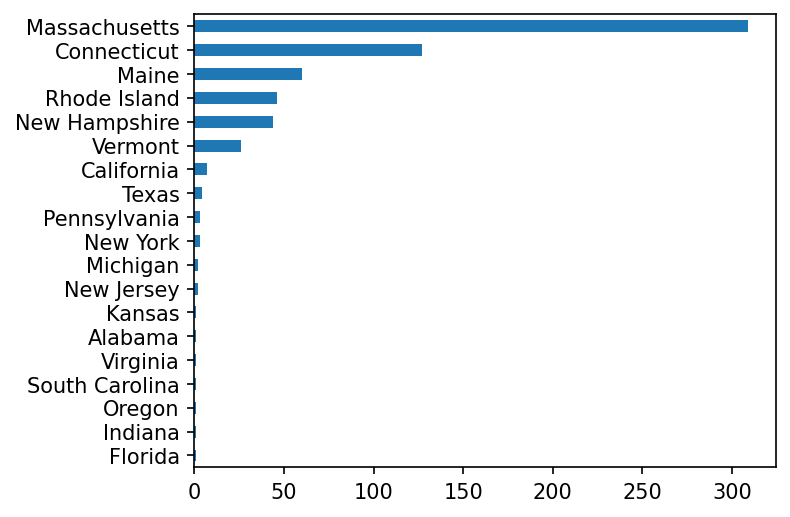

In [14]:
# Respondents by state
print('%s\n'%codebook['Q_US_state']['Q'])
fig,ax = plt.subplots(figsize=(5,4), dpi=150)
respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_US_state'].value_counts().sort_values().rename(
    codebook['Q_US_state']['choices']))

How old are you?


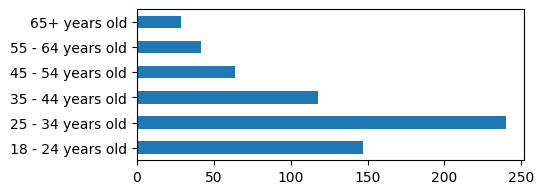

In [15]:
print('%s'%codebook['Q_demos_age']['Q'])
fig,ax = plt.subplots(figsize=(5,2), dpi=100)
_ = respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_age'].value_counts().sort_index().rename(codebook['Q_demos_age']['choices']))

What was your total household income before taxes during the past 12 months?



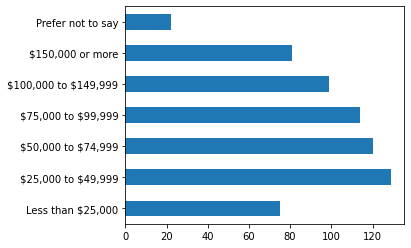

In [16]:
print('%s\n'%codebook['Q_demos_income']['Q'])
fig,ax = plt.subplots(figsize=(5,4))#, dpi=100)
_ = respondent_df['Q_demos_income'].value_counts().sort_index().rename(
    codebook['Q_demos_income']['choices']).plot.barh(ax=ax)
# print(respondent_df['Q_demos_income'].value_counts().sort_index().rename(codebook['Q_demos_income']['choices']))

                      count   (%)
gender                           
Female                  354  55.3
Male                    265  41.4
Other                    19   3.0
Prefer not to answer      2   0.3


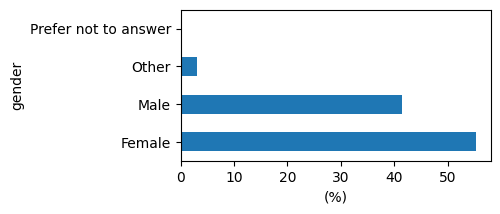

In [17]:
respondent_df['gender'] = respondent_df.Q_demos_gender.map(codebook['Q_demos_gender']['choices'])
fig,ax = plt.subplots(figsize=(4,2),dpi=100)
gender_counts = respondent_df.groupby(
    'gender'
)['ResponseId'].count().rename('count').to_frame()
gender_counts['(%)'] = 100*round(gender_counts['count']/gender_counts['count'].sum(), 3)
print(gender_counts)
gender_counts['(%)'].plot.barh(ax=ax)
_ = ax.set_xlabel('(%)')

1,2,4      1
1,4,5      1
1,5        1
5          1
3          1
2,4        1
1,3        4
1,6        5
6          7
7          8
1,4        8
1,2        8
2         26
4         41
1        527
Name: Q_demos_race, dtype: int64


Native Hawaiian or Other Pacific Islander             1
American Indian/Native American or Alaska Native      1
Black or African American                            26
Asian                                                41
Other                                                44
White or Caucausian                                 527
Name: race, dtype: int64

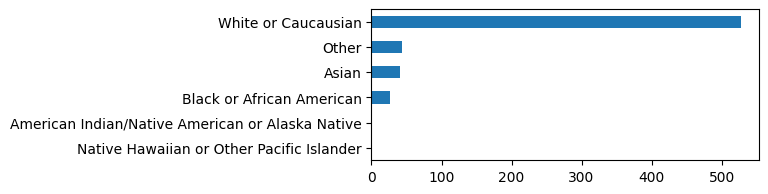

In [18]:
# Race: We put anyone who answered with 2 or more races or 'Prefer not to say' 
# in the 'Other' category
print(respondent_df['Q_demos_race'].value_counts().sort_values())
respondent_df['race'] = (respondent_df['Q_demos_race']
                       .apply(lambda r: r if r in ['1','2','3','4','5'] else '6')
                       .map(codebook['Q_demos_race']['choices']))
fig,ax = plt.subplots(1,1,figsize=(5,2),dpi=100)
respondent_df['race'].value_counts().sort_values().plot.barh()
respondent_df['race'].value_counts().sort_values()

Strongly Democratic    177
Democratic             185
Lean Democratic        168
Lean Republican         78
Republican              24
Strongly Republican      8
Name: Q_politics, dtype: int64


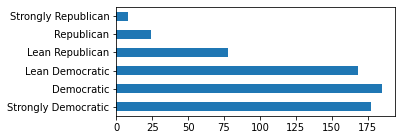

In [19]:
fig,ax = plt.subplots(figsize=(5,2))
respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']).plot.barh(ax=ax)
print(respondent_df.Q_politics.value_counts().sort_index().rename(
    codebook['Q_politics']['choices']))

Which best describes the area you live?


Suburban    381
Urban       157
Rural       102
Name: Q_live_urban, dtype: int64

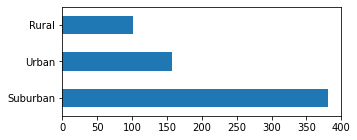

In [20]:
print(codebook['Q_live_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_live_urban'].value_counts().rename(
    codebook['Q_live_urban']['choices'])

Do you work in an urban area?


No                  390
Yes                 229
Not sure / Other     21
Name: Q_work_urban, dtype: int64

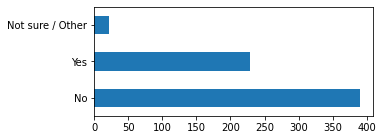

In [21]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Add a column indicating someone either lives or works in an urban area

In [22]:
def live_or_work_urban(row):
    return (row['Q_live_urban'] == '1') or (row['Q_work_urban'] == '1')

respondent_df['live_or_work_urban'] = respondent_df.apply(live_or_work_urban, axis=1)

Do you work in an urban area?


No                  390
Yes                 229
Not sure / Other     21
Name: Q_work_urban, dtype: int64

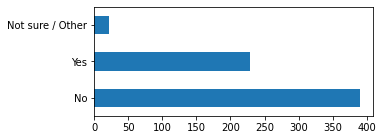

In [23]:
print(codebook['Q_work_urban']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices']).plot.barh(ax=ax)
respondent_df['Q_work_urban'].value_counts().rename(
    codebook['Q_work_urban']['choices'])

Live or work urban

Live or work urban


False    374
True     266
Name: live_or_work_urban, dtype: int64

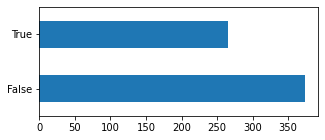

In [24]:
print('Live or work urban')
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['live_or_work_urban'].value_counts().plot.barh(ax=ax)
respondent_df['live_or_work_urban'].value_counts()

More correlations between covariates

In [25]:
def styled_boxplot(df, by, column=None, ax=None):
    df.boxplot(
        column=column,
        by=by, ax=ax,
        grid=False,
        vert=False,
        showmeans=True,
        meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick'),
        boxprops=dict(linestyle='-', linewidth=1.5),
        flierprops=dict(linestyle='-', linewidth=1.5),
        medianprops=dict(linestyle='-', linewidth=2, color='firebrick'),
        whiskerprops=dict(linestyle='-', linewidth=1.5),
        #capprops=dict(linestyle='-', linewidth=1.5),
        showfliers=False,
        rot=0
    ).get_figure().suptitle('') # remove title automatically added by pandas

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator


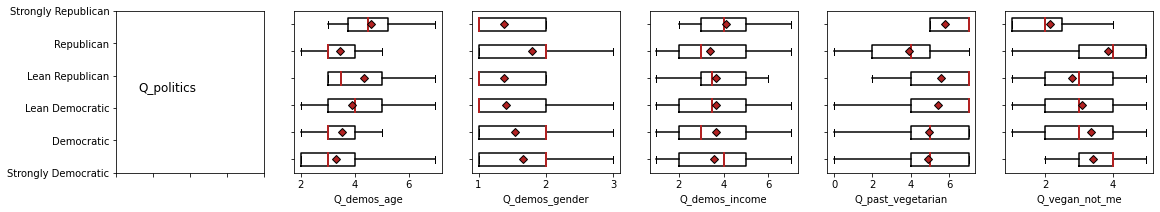

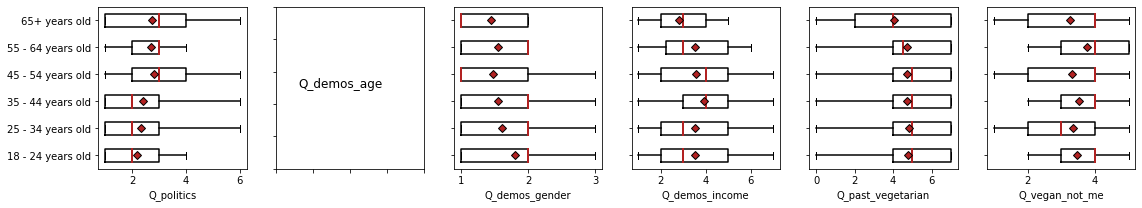

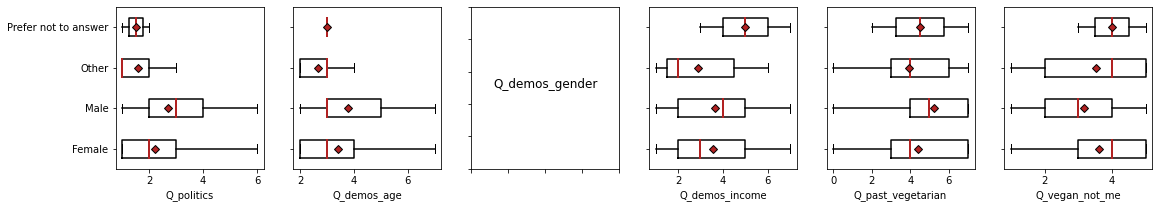

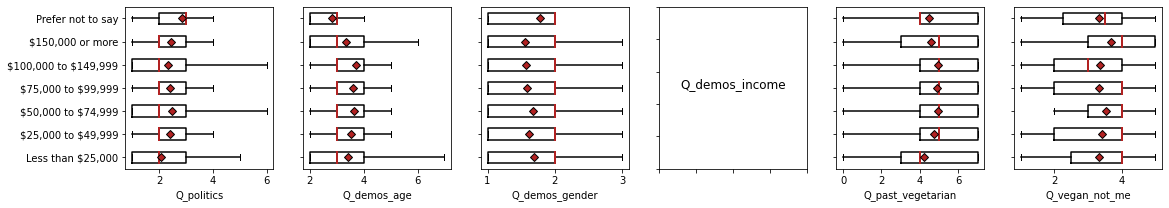

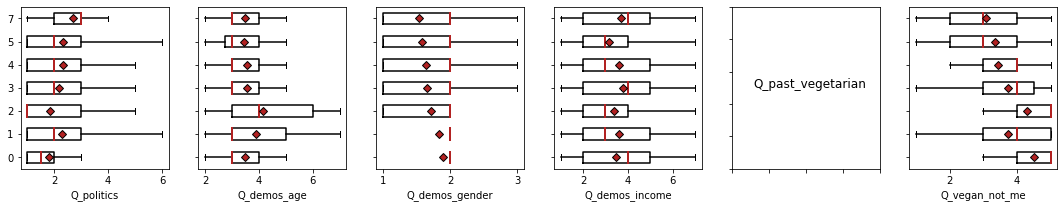

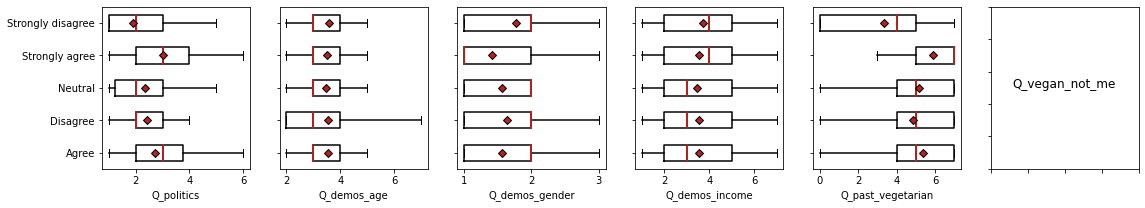

In [26]:
# Covariates correlations
cc_list = [
    'Q_politics', 
    'Q_demos_age', 
    'Q_demos_gender', 
    'Q_demos_income',
    'Q_past_vegetarian',
    'Q_vegan_not_me',
    
]
# make a df for analysis
df = respondent_df[cc_list].copy()


alt_map = ['Q_demos_income']
n_ccs = len(cc_list)


for i in range(n_ccs):
    fig, axes = plt.subplots(1,n_ccs, figsize=(3*n_ccs,3),
                             facecolor='w', edgecolor='k')
    for j in range(n_ccs):
        ax = axes[j]
        cc_i = cc_list[i]
        cc_j = cc_list[j]
        if i == j:
            if i == 0:
                ax.set_yticklabels(list(codebook[cc_i]['choices'].values()))
            else:
                ax.set_yticklabels([])
            ax.text(0.15, 0.5, cc_i, fontsize = 12)
            ax.set_xticklabels([])
            continue
        rdf = df[[cc_i, cc_j]].copy()
        if cc_i not in alt_map:
            rdf[cc_i] = rdf[cc_i].map(codebook[cc_i]['choices'])
        rdf[cc_j] = rdf[cc_j].astype(float)
        styled_boxplot(rdf, by=cc_i, column=cc_j, ax=ax)
        if j > 0:
            ax.set_yticklabels([])
        if (cc_i in alt_map) and (j==0):
            ax.set_yticklabels(codebook[cc_i]['choices'].values())
        ax.set_xlabel(cc_j)
        ax.set_title('')
        # ax.set_title('%s' % (cc_j))

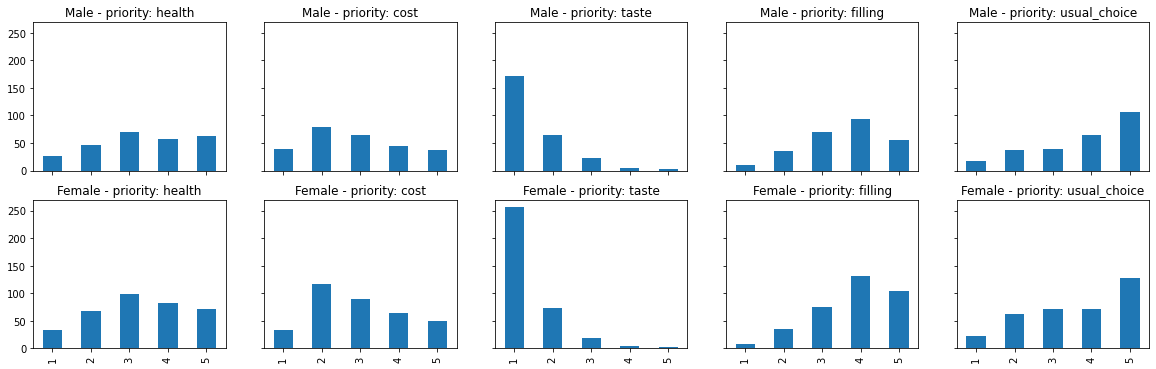

In [27]:
priorities_N = len(codebook['Q_priorities']['choices'])
fig, axes = plt.subplots(2, priorities_N, figsize=(4*priorities_N, 3*2), sharey=True, sharex=True)
for g, gender in enumerate(['Male','Female']):
    g_df = respondent_df[respondent_df['gender']==gender]
    for i, (p, priority) in enumerate(codebook['Q_priorities']['choices'].items()):
        Q_priority = 'Q_priorities_%s'%p
        ax = axes[g][i]
        ax.set_title('%s - priority: %s' % (gender, priority))
        g_df[Q_priority].value_counts().sort_index().plot.bar(ax=ax)
    


How would you rank your current hunger level on a scale from 1 - 4?
1    118
2    247
3    221
4     54
Name: Q_current_hunger, dtype: int64


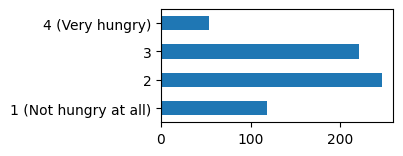

In [28]:
print(codebook['Q_current_hunger']['Q'])
fig,ax = plt.subplots(figsize=(3,1.5), dpi=100)
respondent_df['Q_current_hunger'].value_counts().sort_index().rename(codebook['Q_current_hunger']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_current_hunger'].value_counts().sort_index())

None           523
Vegetarian      39
Other           28
Pescatarian     14
Keto            10
Vegan            7
Gluten free      6
Name: Q_special_diet, dtype: int64


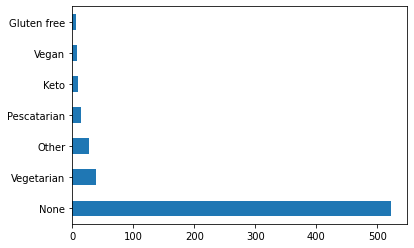

In [29]:
respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts().plot.barh()
print(respondent_df.Q_special_diet.map(codebook['Q_special_diet']['choices']).value_counts())

In [30]:
"""
Add in diet specific varaibles:
is_vegetarian
is_vegan
is_v : (is_vegetarian|is_vegan)
diet_other : said had a special diet that is not veg
diet_none : answered None for special diet
"""
respondent_df['is_vegetarian'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('3' in d) else 0)
respondent_df['is_vegan'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if ('5' in d) else 0)
respondent_df['is_v'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: 1 if (('3' in d) or ('5' in d)) else 0)
respondent_df['diet_other'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: ('3' not in d) and ('5' not in d) and ('7' not in d))
respondent_df['diet_none'] = respondent_df['Q_special_diet'].astype(str).apply(lambda d: '7' in d)
respondent_df['diet_none'].sum()

524

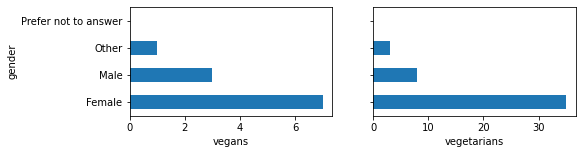

In [31]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,2),sharey=True)
respondent_df.groupby('gender')['is_vegan'].sum().plot.barh(ax=ax1)
respondent_df.groupby('gender')['is_vegetarian'].sum().plot.barh(ax=ax2)
ax1.set_xlabel('vegans')
_ = ax2.set_xlabel('vegetarians')

How strongly do you agree with the following statement?
"Vegan dishes are not for people like me."



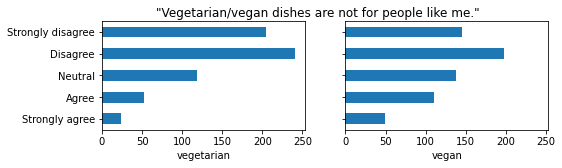

In [32]:
print('%s\n'%codebook['Q_vegan_not_me']['Q'])
fig,axes = plt.subplots(1,2,figsize=(8,2),sharey=True,sharex=True)
fig.suptitle('"Vegetarian/vegan dishes are not for people like me."')
respondent_df['Q_vegetarian_not_me'].value_counts().sort_index().rename(
    codebook['Q_vegetarian_not_me']['choices']).plot.barh(ax=axes[0])
axes[0].set_xlabel("vegetarian")
respondent_df['Q_vegan_not_me'].value_counts().sort_index().rename(
    codebook['Q_vegan_not_me']['choices']).plot.barh(ax=axes[1])
_ = axes[1].set_xlabel("vegan")

How important is environmental sustainability to you as an issue?
Very much not important     20
Not important               33
Neutral                     63
Somewhat important         277
Very important             247
Name: Q_how_important_env, dtype: int64


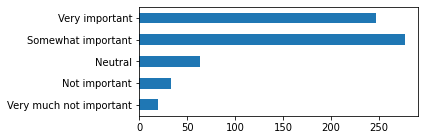

In [33]:
print(codebook['Q_how_important_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_how_important_env'].value_counts().sort_index().rename(codebook['Q_how_important_env']['choices']))

How strongly do you agree with the following statement?
"Vegetarian and vegan dishes are good for the environment."

Strongly agree       165
Agree                290
Neutral              164
Disagree              14
Strongly disagree      7
Name: Q_good_for_env, dtype: int64


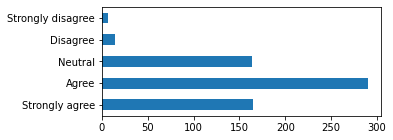

In [34]:
print('%s\n'%codebook['Q_good_for_env']['Q'])
fig,ax = plt.subplots(figsize=(5,2))
respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']).plot.barh(ax=ax)
print(respondent_df['Q_good_for_env'].value_counts().sort_index().rename(codebook['Q_good_for_env']['choices']))

Code boolean (0/1) for whether people said env sustainability is important to them AND agree with the statement: "Vegetarian and vegan dishes are good for the environment."

In [35]:
print(codebook['Q_how_important_env'])
print(codebook['Q_good_for_env'])

{'Q': 'How important is environmental sustainability to you as an issue?', 'choices': {'1': 'Very much not important', '2': 'Not important', '3': 'Neutral', '4': 'Somewhat important', '5': 'Very important'}}
{'Q': 'How strongly do you agree with the following statement?\n"Vegetarian and vegan dishes are good for the environment."', 'choices': {'1': 'Strongly agree', '2': 'Agree', '3': 'Neutral', '4': 'Disagree', '5': 'Strongly disagree'}}


In [36]:
def get_v_important(row):
    if (row['Q_how_important_env'] in ['4','5']) and (row['Q_good_for_env'] in ['1','2']):
        return 1
    return 0
respondent_df['v_important'] = respondent_df.apply(get_v_important, axis=1)
# respondent_df[['v_important','Q_how_important_env','Q_good_for_env']].head()

### Menu choices table

```
ResponseId, labeled (0/1), QID, menu, choice_type (1-5), choice (1,2) 
```

In [37]:
# Wide data
choices_wide_df = (survey_df[['ResponseId'] + choice_Qs].drop([0,1]))
# drop data from respondents who failed attention checks
choices_wide_df = choices_wide_df[
    (choices_wide_df.ResponseId.isin(passed_attn_checks_ResponseId_list))
]
choices_wide_df.head(3)

,ResponseId,Q_sandwich_1,Q_sandwich_2,Q_sandwich_3,Q_sandwich_4,Q_sandwich_5,Q_sandwich_1_labeled,Q_sandwich_2_labeled,Q_sandwich_3_labeled,Q_sandwich_4_labeled,Q_sandwich_5_labeled
2,R_125SdSXI0xLI29S,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1
3,R_23V4Eyckqxl6Bmy,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN
4,R_2c5wLF9HxTeZ30h,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0


In [38]:
# Transform the wide data to long data.
choices_df = pd.melt(choices_wide_df, 
                     id_vars=['ResponseId'], value_vars=choice_Qs, 
                     var_name='QID', value_name='choice')
choices_df.head()

,ResponseId,QID,choice
0,R_125SdSXI0xLI29S,Q_sandwich_1,NaN
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0
2,R_2c5wLF9HxTeZ30h,Q_sandwich_1,NaN
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0
4,R_2BrfiuSgy1SNVbL,Q_sandwich_1,NaN


In [39]:
# Add Q data
# ResponseId, labeled (0/1), QID, choice_type (1-5), choice (1/0)
# code choice, choice_type, labeled as numeric
choices_df['choice_type'] = choices_df['QID'].apply(lambda QID: int(QID.split('_')[2]))
choices_df['labeled'] = choices_df['QID'].apply(lambda QID: 1 if len(QID.split('_')) > 3 and QID.split('_')[3] == 'labeled' else 0)
# only keep responses for answered questions
print('dropping unanswered Qs; respondents answer %s = %s/%s of total Qs' % (
    len(choices_df.dropna())/len(choices_df), len(choices_df.dropna()), len(choices_df)
))
choices_df = choices_df.dropna()
choices_df['choice'] = choices_df['choice'].astype(int)
choices_df.head()

dropping unanswered Qs; respondents answer 0.5 = 3200/6400 of total Qs


,ResponseId,QID,choice,choice_type,labeled
1,R_23V4Eyckqxl6Bmy,Q_sandwich_1,0,1,0
3,R_2B97XuOwuxSeQWA,Q_sandwich_1,0,1,0
5,R_1DBZC4pjzVDsgT6,Q_sandwich_1,0,1,0
8,R_2SdGAfdbJx8Aq5C,Q_sandwich_1,0,1,0
11,R_2xL9vHDm0KfOgCa,Q_sandwich_1,0,1,0


## Modeling


## Main effects by comparison type

In [40]:
choices_type_names_dict = {
    1:'1=(labeled) vegetarian vs 0=meat',
    2:'1=(labeled) vegan vs 0=meat',
    3:'1=(labeled) vegetarian vs 0=vegetarian',
    4:'1=(labeled) vegan vs 0=vegan',
    5:'1=(labeled) vegan vs 0=vegetarian',
}

Add in demographic covariates to choices df

In [41]:
# code gender as male=1; otherwise=0
response_genders = respondent_df.set_index('ResponseId')['Q_demos_gender']
choices_df['male'] = choices_df['ResponseId'].apply(lambda r: 1 if response_genders[r]=='1' else 0)
# choices_df

In [42]:
choices_df['age'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_age'])
choices_df['income'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_demos_income'])
choices_df['race'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['race'])

In [43]:
# Put in the diet related variables
for d in ['is_v', 'is_vegetarian', 'is_vegan']:
    choices_df[d] = choices_df.ResponseId.map(respondent_df.set_index('ResponseId')[d])

Test for for non-veg

In [44]:
def get_non_veg_choices_df(df):
    return df[(choices_df.is_v==0)]

By choice type

In [45]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.600914
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      584
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                0.004720
Time:                        18:12:52   Log-Likelihood:                -352.14
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                   0.06763
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7286  

By choice type, considering gender

In [46]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.587506
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      583
Method:                           MLE   Df Model:                            2
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02693
Time:                        18:12:52   Log-Likelihood:                -344.28
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 7.287e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4216  

In [47]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.587498
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02694
Time:                        18:12:52   Log-Likelihood:                -344.27
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0002654
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

With demographic covariates

In [48]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.576810
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                           13
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.04464
Time:                        18:12:52   Log-Likelihood:                -338.01
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                  0.002763
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.258

Optimization terminated successfully.
         Current function value: 0.683124
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                           13
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.01113
Time:                        18:12:52   Log-Likelihood:                -400.31
converged:                       True   LL-Null:                       -404.82
Covariance Type:            nonrobust   LLR p-value:                    0.7718
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2816      0.294     -0.959      0.337      -0.857       0.294
age[T.3]       -0.1020    

In [49]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + labeled:male + age + income", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.576809
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      571
Method:                           MLE   Df Model:                           14
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.04464
Time:                        18:12:52   Log-Likelihood:                -338.01
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                  0.004579
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.

                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      571
Method:                           MLE   Df Model:                           14
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.01114
Time:                        18:12:53   Log-Likelihood:                -400.31
converged:                       True   LL-Null:                       -404.82
Covariance Type:            nonrobust   LLR p-value:                    0.8296
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2742      0.304     -0.901      0.367      -0.871       0.322
age[T.3]        -0.1019      0.228     -0.447      0.655      -0.549       0.345
age[T.4]         0.0952      0.265      0.35

Alternative coding for gender:

gender = non-male/male: -0.5 / +0.5

so that “labeled” can be interpreted as an average effect when coding interaction

In [50]:
choices_df['gender'] = choices_df['male'].apply(lambda m: -0.5 if m == 0 else 0.5)

In [51]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\ngender = non-male/male: -0.5 / +0.5\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + gender", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------
gender = non-male/male: -0.5 / +0.5

Optimization terminated successfully.
         Current function value: 0.587506
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      583
Method:                           MLE   Df Model:                            2
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02693
Time:                        18:12:53   Log-Likelihood:                -344.28
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 7.287e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In [52]:
# with interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\ngender = non-male/male: -0.5 / +0.5\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + gender + labeled:gender", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------
gender = non-male/male: -0.5 / +0.5

Optimization terminated successfully.
         Current function value: 0.587498
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02694
Time:                        18:12:53   Log-Likelihood:                -344.27
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0002654
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

## Tests with moderator variables

Test moderation impact of whether participants state environmental sustainability is important to them and agree vegan/vegetarian meals are good for the environment.

Do vegan/vegetarian labels will still have a negative impact on participants who state environmental sustainability is important to them and agree vegan/vegetarian meals are good for the environment?

How does this compare to the impact of the past number of days someone did not eat meat?

What does this say about education campaigns?


In [53]:
choices_df['past_days_v'] = 7 - choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_past_vegetarian'].astype(int))

In [54]:
# v_important = 0/1; 
# 1 if participants stated environmental sustainability 
# is important to them and agree vegan/vegetarian meals are good for the environment
choices_df['v_important'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['v_important'])

In [55]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + v_important + labeled:v_important", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.586700
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02826
Time:                        18:12:53   Log-Likelihood:                -343.81
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0001698
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

In [56]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + past_days_v + labeled:past_days_v", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.569457
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.05682
Time:                        18:12:53   Log-Likelihood:                -333.70
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 9.629e-09
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inter

Test people's agreement with the statement that 'vegan dishes are not for people like me' as a moderator variable.

In [57]:
choices_df['vegan_not_me'] = choices_df.ResponseId.map(
    respondent_df.set_index('ResponseId')['Q_vegan_not_me']).astype(int)

In [58]:
codebook['Q_vegan_not_me']['choices']

{'1': 'Strongly agree',
 '2': 'Agree',
 '3': 'Neutral',
 '4': 'Disagree',
 '5': 'Strongly disagree'}

In [59]:
# without interaction
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + vegan_not_me + labeled:vegan_not_me", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.575608
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.04663
Time:                        18:12:53   Log-Likelihood:                -337.31
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 1.195e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Int

Test with is_vegetarian and is_vegan as moderators

In [60]:
for choice_type in choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = choices_df[choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ male + is_vegetarian + labeled + labeled:is_vegetarian", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

         Current function value: 0.565298
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  640
Model:                          Logit   Df Residuals:                      635
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                  0.1256
Time:                        18:12:53   Log-Likelihood:                -361.79
converged:                      False   LL-Null:                       -413.74
Covariance Type:            nonrobust   LLR p-value:                 1.450e-21
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4069     

/Users/aberke/projects/ff/venv-ff/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Test with priority:health as a moderator, using whether health rated in top 2 priorities

Also: 
Test with priority:filling as a moderator, using whether health rated in top 2 priorities

In [61]:
Q_priorities_col_map = {'Q_priorities_%s'%k:'Q_priorities_%s'%v for k,v in codebook['Q_priorities']['choices'].items()}
# Q_priorities_col_map

In [62]:
# priority_health: whether health in top 1-2 priorities
choices_df['priority_health'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_health'].apply(lambda h: 1 if h in ['1','2'] else 0))

# priority_filling: whether filling in top 1-2 priorities
choices_df['priority_filling'] = choices_df['ResponseId'].map(respondent_df.set_index('ResponseId').rename(
    columns=Q_priorities_col_map
)['Q_priorities_filling'].apply(lambda p: 1 if p in ['1','2'] else 0))
# choices_df['priority_filling'].head(10)

In [63]:
# with priority health as a moderator
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + priority_health + labeled:priority_health", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.583632
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.03334
Time:                        18:12:53   Log-Likelihood:                -342.01
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 9.635e-05
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

With priority filling and hunger level as moderators

In [64]:
print('%0.2f respondents prioritize filling' % (choices_df['priority_filling'].sum()/len(choices_df)))

0.14 respondents prioritize filling


For hunger, we code current hunger level 3, 4 as hungry.

In [65]:
choices_df['hungry'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['Q_current_hunger'].apply(lambda h: 1 if h in ['3','4'] else 0)
)
print('%0.2f respondents are hungry' % (choices_df['hungry'].sum()/len(choices_df)))

choices_df['hungry_or_prioritize_filling'] = \
    choices_df.apply(lambda r: 1 if (r['hungry'] + r['priority_filling'] > 0) else 0, axis=1)

print('%0.2f respondents are hungry or priotize filling' % (choices_df['hungry_or_prioritize_filling'].sum()/len(choices_df)))

0.43 respondents are hungry
0.51 respondents are hungry or priotize filling


In [66]:
# with priority filling as a moderator
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (
        choice_type, choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit(
        "choice ~ labeled + male + hungry_or_prioritize_filling + labeled:hungry_or_prioritize_filling", 
        data=c_df
    ).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.587058
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02767
Time:                        18:12:54   Log-Likelihood:                -344.02
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0006048
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                0.005492
Time:                        18:12:54   Log-Likelihood:                -389.49
converged:                       True   LL-Null:                       -391.64
Covariance Type:            nonrobust   LLR p-value:                    0.3667
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.3329      0.187     -1.783      0.075      -0.699       0.033
labeled                                 -0.3130      

With political leaning as moderator (non-veg only)

Note responses are skewed towards democratic learning participants

In [67]:
choices_df['politics'] = \
    choices_df['ResponseId'].map(respondent_df.set_index('ResponseId')['Q_politics'].astype(float))
choices_df['politics'].describe()

count    3200.000000
mean        2.392187
std         1.187726
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: politics, dtype: float64

In [68]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + politics + labeled:politics", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.587836
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      582
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02638
Time:                        18:12:54   Log-Likelihood:                -344.47
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0003203
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept  

With urban as moderator (menu: sandwich; non-veg only)

In [69]:
choices_df['live_or_work_urban'] = choices_df['ResponseId'].map(
    respondent_df.set_index('ResponseId')['live_or_work_urban'].apply(lambda u: 1 if u else 0))
# choices_df['live_or_work_urban']

In [70]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
for choice_type in non_veg_choices_df.choice_type.unique():
    print('\n-------- Model for comparison type %s ( %s ) --------\n' % (choice_type,choices_type_names_dict[choice_type]))
    c_df = non_veg_choices_df[non_veg_choices_df.choice_type == choice_type]
    choice_type_model = smf.logit("choice ~ labeled + male + live_or_work_urban + labeled:live_or_work_urban", data=c_df).fit()
    print(choice_type_model.summary())
    choice_type_model_odds = pd.DataFrame(np.exp(choice_type_model.params), columns=['OR'])
    choice_type_model_odds['z-value'] = choice_type_model.pvalues
    choice_type_model_odds[['2.5%', '97.5%']] = np.exp(choice_type_model.conf_int())
    print(choice_type_model_odds)


-------- Model for comparison type 1 ( 1=(labeled) vegetarian vs 0=meat ) --------

Optimization terminated successfully.
         Current function value: 0.586117
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                 0.02923
Time:                        18:12:54   Log-Likelihood:                -343.46
converged:                       True   LL-Null:                       -353.81
Covariance Type:            nonrobust   LLR p-value:                 0.0003662
                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.663696
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 choice   No. Observations:                  586
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Jul 2022   Pseudo R-squ.:                0.006940
Time:                        18:12:54   Log-Likelihood:                -388.93
converged:                       True   LL-Null:                       -391.64
Covariance Type:            nonrobust   LLR p-value:                    0.2454
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.4002      0.169     -2.366      0.018      

### Multilevel modeling


We also use a hierarchical logistic regression model, where choices from all choice types are included in the model, and the participant-level effect is controlled for.

In [71]:
from pymer4.models import Lmer

In [72]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + (1|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1872.446 	 AIC: 3750.891

Random effects:

                   Name  Var    Std
ResponseId  (Intercept)  0.3  0.548

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.599,-0.726,-0.472,0.065,0.549,0.484,0.624,0.355,0.326,0.384,-9.243,0.000,***
labeled,-0.192,-0.373,-0.011,0.092,0.825,0.689,0.989,0.452,0.408,0.497,-2.076,0.038,*


In [73]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + gender + (1|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+gender+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1871.080 	 AIC: 3750.161

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.295  0.543

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.608,-0.735,-0.481,0.065,0.545,0.479,0.618,0.353,0.324,0.382,-9.356,0.000,***
labeled,-0.195,-0.376,-0.014,0.092,0.823,0.687,0.986,0.451,0.407,0.497,-2.109,0.035,*
gender,-0.154,-0.337,0.029,0.093,0.857,0.714,1.029,0.462,0.417,0.507,-1.654,0.098,.


In [74]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + gender + labeled:gender + (1|ResponseId)", data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+gender+labeled:gender+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1870.859 	 AIC: 3751.719

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.294  0.542

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.612,-0.739,-0.484,0.065,0.542,0.477,0.616,0.352,0.323,0.381,-9.374,0.000,***
labeled,-0.185,-0.368,-0.003,0.093,0.831,0.692,0.997,0.454,0.409,0.499,-1.987,0.047,*
gender,-0.213,-0.466,0.039,0.129,0.808,0.627,1.040,0.447,0.385,0.510,-1.654,0.098,.
labeled:gender,0.124,-0.241,0.490,0.186,1.132,0.786,1.632,0.531,0.440,0.620,0.666,0.506,


With demographic covariates

In [75]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + gender + (1|ResponseId) + age + income", data=non_veg_choices_df, family="binomial")
m.fit()

Model failed to converge with max|grad| = 0.0162222 (tol = 0.001, component 1) 

Formula: choice~labeled+gender+(1|ResponseId)+age+income

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1862.494 	 AIC: 3754.987

Random effects:

                   Name    Var   Std
ResponseId  (Intercept)  0.261  0.51

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.866,-1.182,-0.549,0.162,0.421,0.307,0.578,0.296,0.235,0.366,-5.356,0.000,***
labeled,-0.184,-0.363,-0.004,0.092,0.832,0.695,0.996,0.454,0.410,0.499,-2.006,0.045,*
gender,-0.194,-0.379,-0.010,0.094,0.823,0.685,0.990,0.452,0.406,0.497,-2.067,0.039,*
age3,0.017,-0.228,0.262,0.125,1.018,0.796,1.300,0.504,0.443,0.565,0.140,0.889,
age4,0.160,-0.124,0.443,0.145,1.173,0.884,1.558,0.540,0.469,0.609,1.106,0.269,
age5,0.267,-0.074,0.608,0.174,1.306,0.928,1.836,0.566,0.481,0.647,1.533,0.125,
age6,0.501,0.108,0.894,0.201,1.650,1.114,2.445,0.623,0.527,0.710,2.497,0.013,*
age7,0.547,0.102,0.993,0.227,1.728,1.107,2.698,0.633,0.525,0.730,2.407,0.016,*
income2,0.067,-0.272,0.406,0.173,1.070,0.762,1.501,0.517,0.433,0.600,0.389,0.697,
income3,0.162,-0.180,0.504,0.174,1.176,0.835,1.655,0.540,0.455,0.623,0.927,0.354,


In [76]:
non_veg_choices_df = get_non_veg_choices_df(choices_df)
m = Lmer("choice ~ labeled + gender + labeled:gender + (1|ResponseId) + age + income", data=non_veg_choices_df, family="binomial")
m.fit()

Model failed to converge with max|grad| = 0.014726 (tol = 0.001, component 1) 

Formula: choice~labeled+gender+labeled:gender+(1|ResponseId)+age+income

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1862.284 	 AIC: 3756.568

Random effects:

                   Name   Var   Std
ResponseId  (Intercept)  0.26  0.51

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.868,-1.185,-0.551,0.162,0.420,0.306,0.576,0.296,0.234,0.366,-5.368,0.000,***
labeled,-0.175,-0.356,0.007,0.093,0.840,0.700,1.007,0.456,0.412,0.502,-1.886,0.059,.
gender,-0.252,-0.504,0.001,0.129,0.778,0.604,1.001,0.437,0.377,0.500,-1.950,0.051,.
age3,0.018,-0.227,0.263,0.125,1.018,0.797,1.301,0.504,0.443,0.565,0.143,0.886,
age4,0.155,-0.129,0.439,0.145,1.168,0.879,1.551,0.539,0.468,0.608,1.070,0.285,
age5,0.268,-0.073,0.609,0.174,1.307,0.929,1.838,0.566,0.482,0.648,1.538,0.124,
age6,0.504,0.111,0.897,0.201,1.656,1.117,2.453,0.623,0.528,0.710,2.513,0.012,*
age7,0.546,0.101,0.991,0.227,1.726,1.106,2.695,0.633,0.525,0.729,2.403,0.016,*
income2,0.065,-0.274,0.404,0.173,1.067,0.761,1.498,0.516,0.432,0.600,0.377,0.706,
income3,0.159,-0.183,0.501,0.175,1.172,0.833,1.650,0.540,0.454,0.623,0.911,0.362,


In [77]:
eq = "choice ~ labeled + (1|ResponseId) + priority_health + labeled:priority_health"
m = Lmer(eq, data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(1|ResponseId)+priority_health+labeled:priority_health

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1865.045 	 AIC: 3740.091

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.273  0.523

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.662,-0.806,-0.518,0.073,0.516,0.447,0.595,0.340,0.309,0.373,-9.025,0.000,***
labeled,-0.268,-0.478,-0.057,0.107,0.765,0.620,0.945,0.433,0.383,0.486,-2.491,0.013,*
priority_health,0.281,-0.010,0.572,0.148,1.324,0.990,1.771,0.570,0.498,0.639,1.893,0.058,.
labeled:priority_health,0.205,-0.200,0.610,0.206,1.227,0.819,1.840,0.551,0.450,0.648,0.993,0.321,


In [78]:
eq = "choice ~ labeled + (1|ResponseId) + past_days_v + labeled:past_days_v + v_important + labeled:v_important"
m = Lmer(eq, data=non_veg_choices_df, family="binomial")
m.fit()

Formula: choice~labeled+(1|ResponseId)+past_days_v+labeled:past_days_v+v_important+labeled:v_important

Family: binomial	 Inference: parametric

Number of observations: 2930	 Groups: {'ResponseId': 586.0}

Log-likelihood: -1855.311 	 AIC: 3724.621

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  0.235  0.485

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.981,-1.201,-0.761,0.112,0.375,0.301,0.467,0.273,0.231,0.318,-8.738,0.000,***
labeled,-0.124,-0.442,0.193,0.162,0.883,0.643,1.213,0.469,0.391,0.548,-0.767,0.443,
past_days_v,0.117,0.048,0.187,0.036,1.124,1.049,1.206,0.529,0.512,0.547,3.300,0.001,***
v_important,0.296,0.036,0.556,0.133,1.345,1.036,1.744,0.573,0.509,0.636,2.230,0.026,*
labeled:past_days_v,0.008,-0.092,0.109,0.051,1.008,0.912,1.115,0.502,0.477,0.527,0.164,0.870,
labeled:v_important,-0.180,-0.551,0.191,0.189,0.835,0.577,1.210,0.455,0.366,0.547,-0.952,0.341,


## Plots

In [79]:
print('TODO')

TODO


## Comments

The survey comments are fun to read. And informative.

High level notes:
- people do not like onions
- some people do not like olives and pointed out that the vegan/vegetarian options had more olives
- some people did not like any of the menu options
- people did not appreciate that political spectrum was presented on a democrat to republican scale
- many people enjoyed/appreciated the study and said so.
- some people enjoyed the roasted attention check

In [80]:
comments = respondent_df.set_index('ResponseId')['Q_comments'].rename('comments').dropna()

for c in comments.to_list():
    print('"%s"\n'%c)

"I do not lean toward either party. I am a libertarian. Unfortunately, your survey doesn't treat libertarians as if they exist at all."

"None, but thank you!"

"ty"

"no"

"No thanks! "

"Enjoyed the study!"

"In a complex economy vegetarian or "vegan" options are only beneficial if they are produced locally. Since many of us live in climates that do not support year round vegetable agriculture that means most of what veggies consume is from somewhere far away and probably in a place lacking in water. Also, there are far more options than Democrat and Republican. Two sides of the same capitalist coin are not a democracy and the cause of much of the worlds problems."

"Thank you for the study, I answered honestly and to the best of my abilities."

"Everything worked great. Thank you and good luck!"

"No"

"could have used a few more attention checks... jk."

"Hope I was helpful"

"No"

"None "

"Enjoyed the survey!"

"no"

"None but I cant eat onions"

"None."

"thanks"

":)"

"No comm